In [31]:
import math
import time
import qiskit
import numpy as np
import pandas as pd
from tqdm import tqdm
from math import e, pi
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization.bloch import Bloch
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_histogram

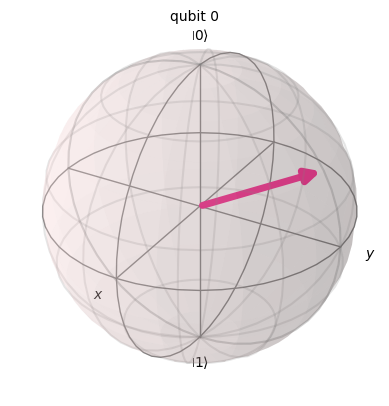

In [8]:
qubit = QuantumCircuit(1,1)
qubit.ry(np.pi/3,0)
qubit.rz(np.pi/2,0)

qubit_state = Statevector(qubit)

plot_bloch_multivector(qubit_state)

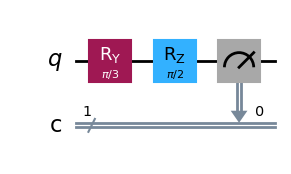

In [10]:
qubit.measure(0,0)
qubit.draw('mpl')

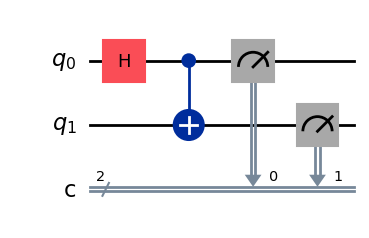

In [11]:
entan = QuantumCircuit(2,2)
entan.h(0)
entan.cx(0,1)
entan.measure([0,1],[0,1])
entan.draw('mpl')

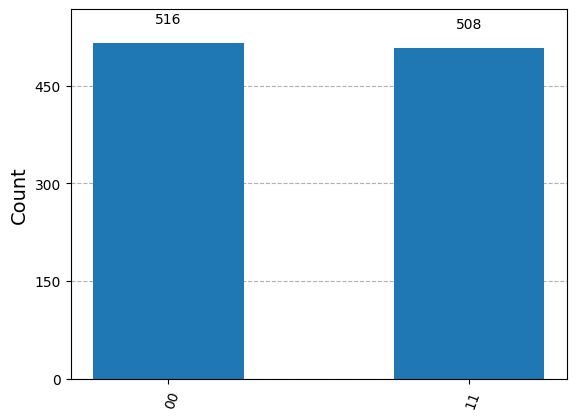

In [27]:
simul = Aer.get_backend('qasm_simulator')
compile = transpile(entan, simul)
result = simul.run(compile, shots=1024).result()
count = result.get_counts()
plot_histogram(count)

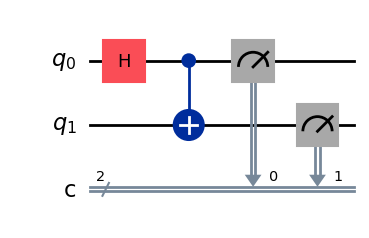

In [17]:
entan = QuantumCircuit(2,2)
entan.h(0)
entan.cx(0,1)
entan.measure([0,1],[0,1])
entan.draw('mpl')

# Related Works

In [28]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

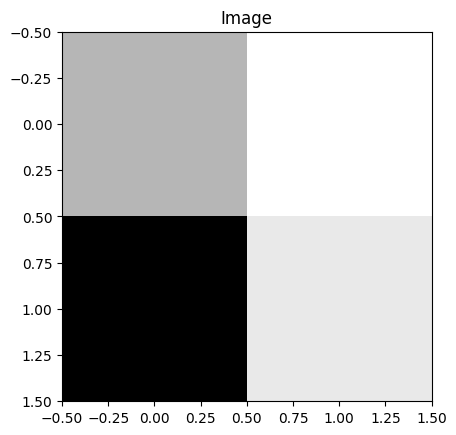

In [29]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

[148, 160, 115, 157] 
 [148 161 116 157]
0.25631 sec


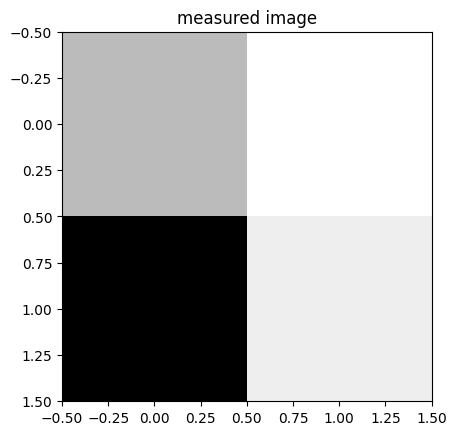

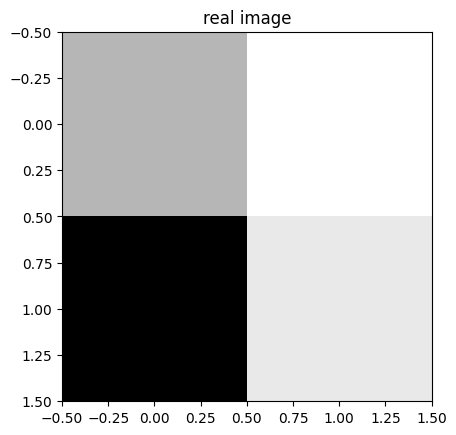

MSE = 0.5


In [39]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_frqi = QuantumCircuit(c, O, cr)
num_qubits = qc_frqi.num_qubits
input_im = image.copy().flatten()
qc_frqi.id(c)
qc_frqi.h(O)
qc_frqi.barrier()
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_frqi.x(O[k])
            
    qc_frqi.barrier()
    # for coord_or_intns in (0,1):
    qc_frqi.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    qc_frqi.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_frqi.x(O[k])
           
    qc_frqi.barrier()

qc_frqi.measure(list(reversed(range(qc_frqi.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_frqi, aer_sim)
result = aer_sim.run(t_qc_image, shots=100000).result()
counts = result.get_counts()

classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))

end = time.time()
print(classical_colors, '\n', input_im)
print(f"{end - start:.5f} sec")

plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

error = []
for i in range(image.size):
    del_ = image.flatten()[i] - classical_colors[i]
    err = del_**2
    error.append(err)
error 

MSE = sum(error)/image.size
print("MSE =",MSE)

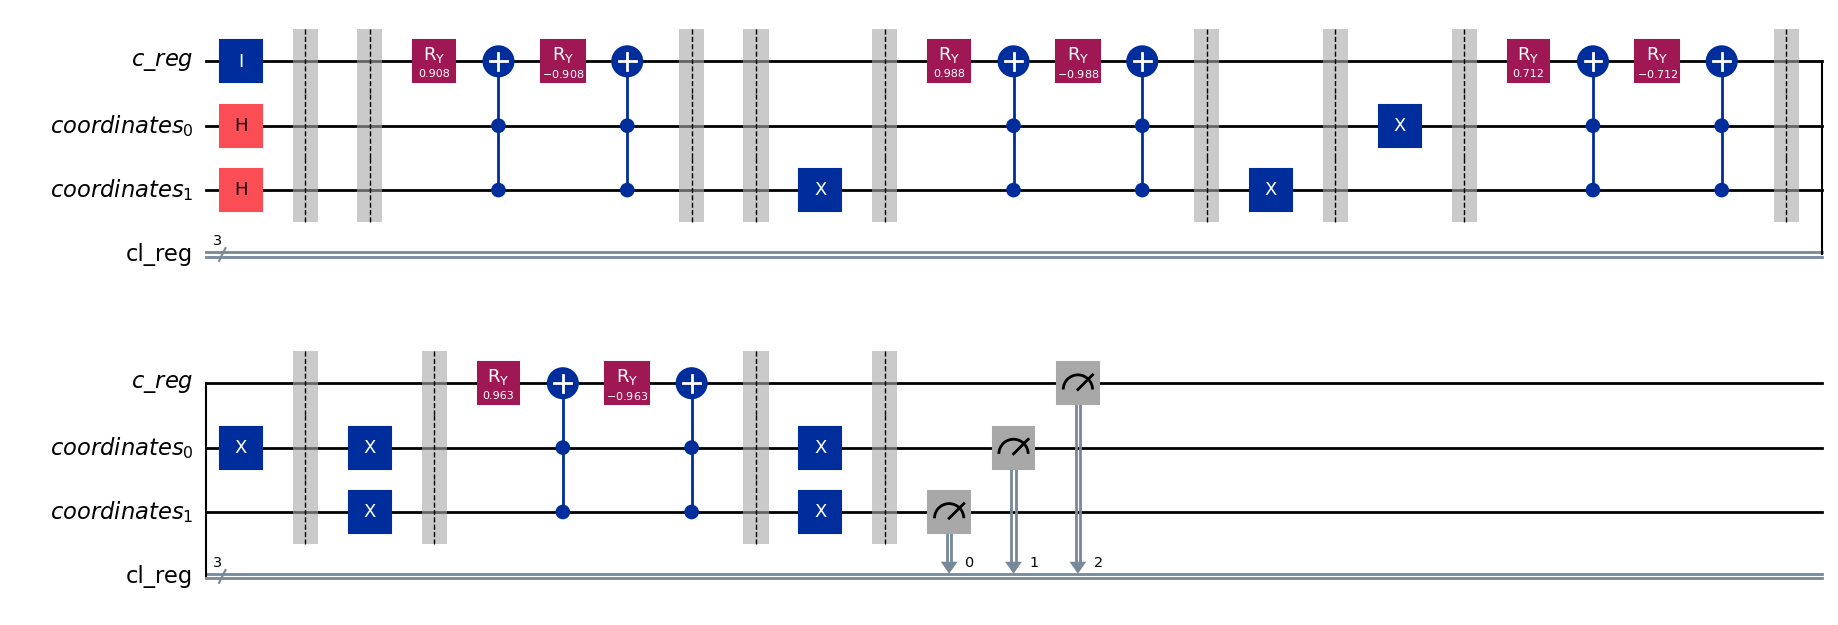

In [33]:
qc_frqi.draw('mpl')

# NEQR

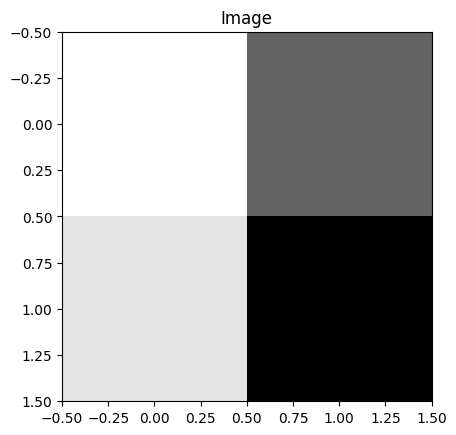

In [40]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

In [42]:
indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.id(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

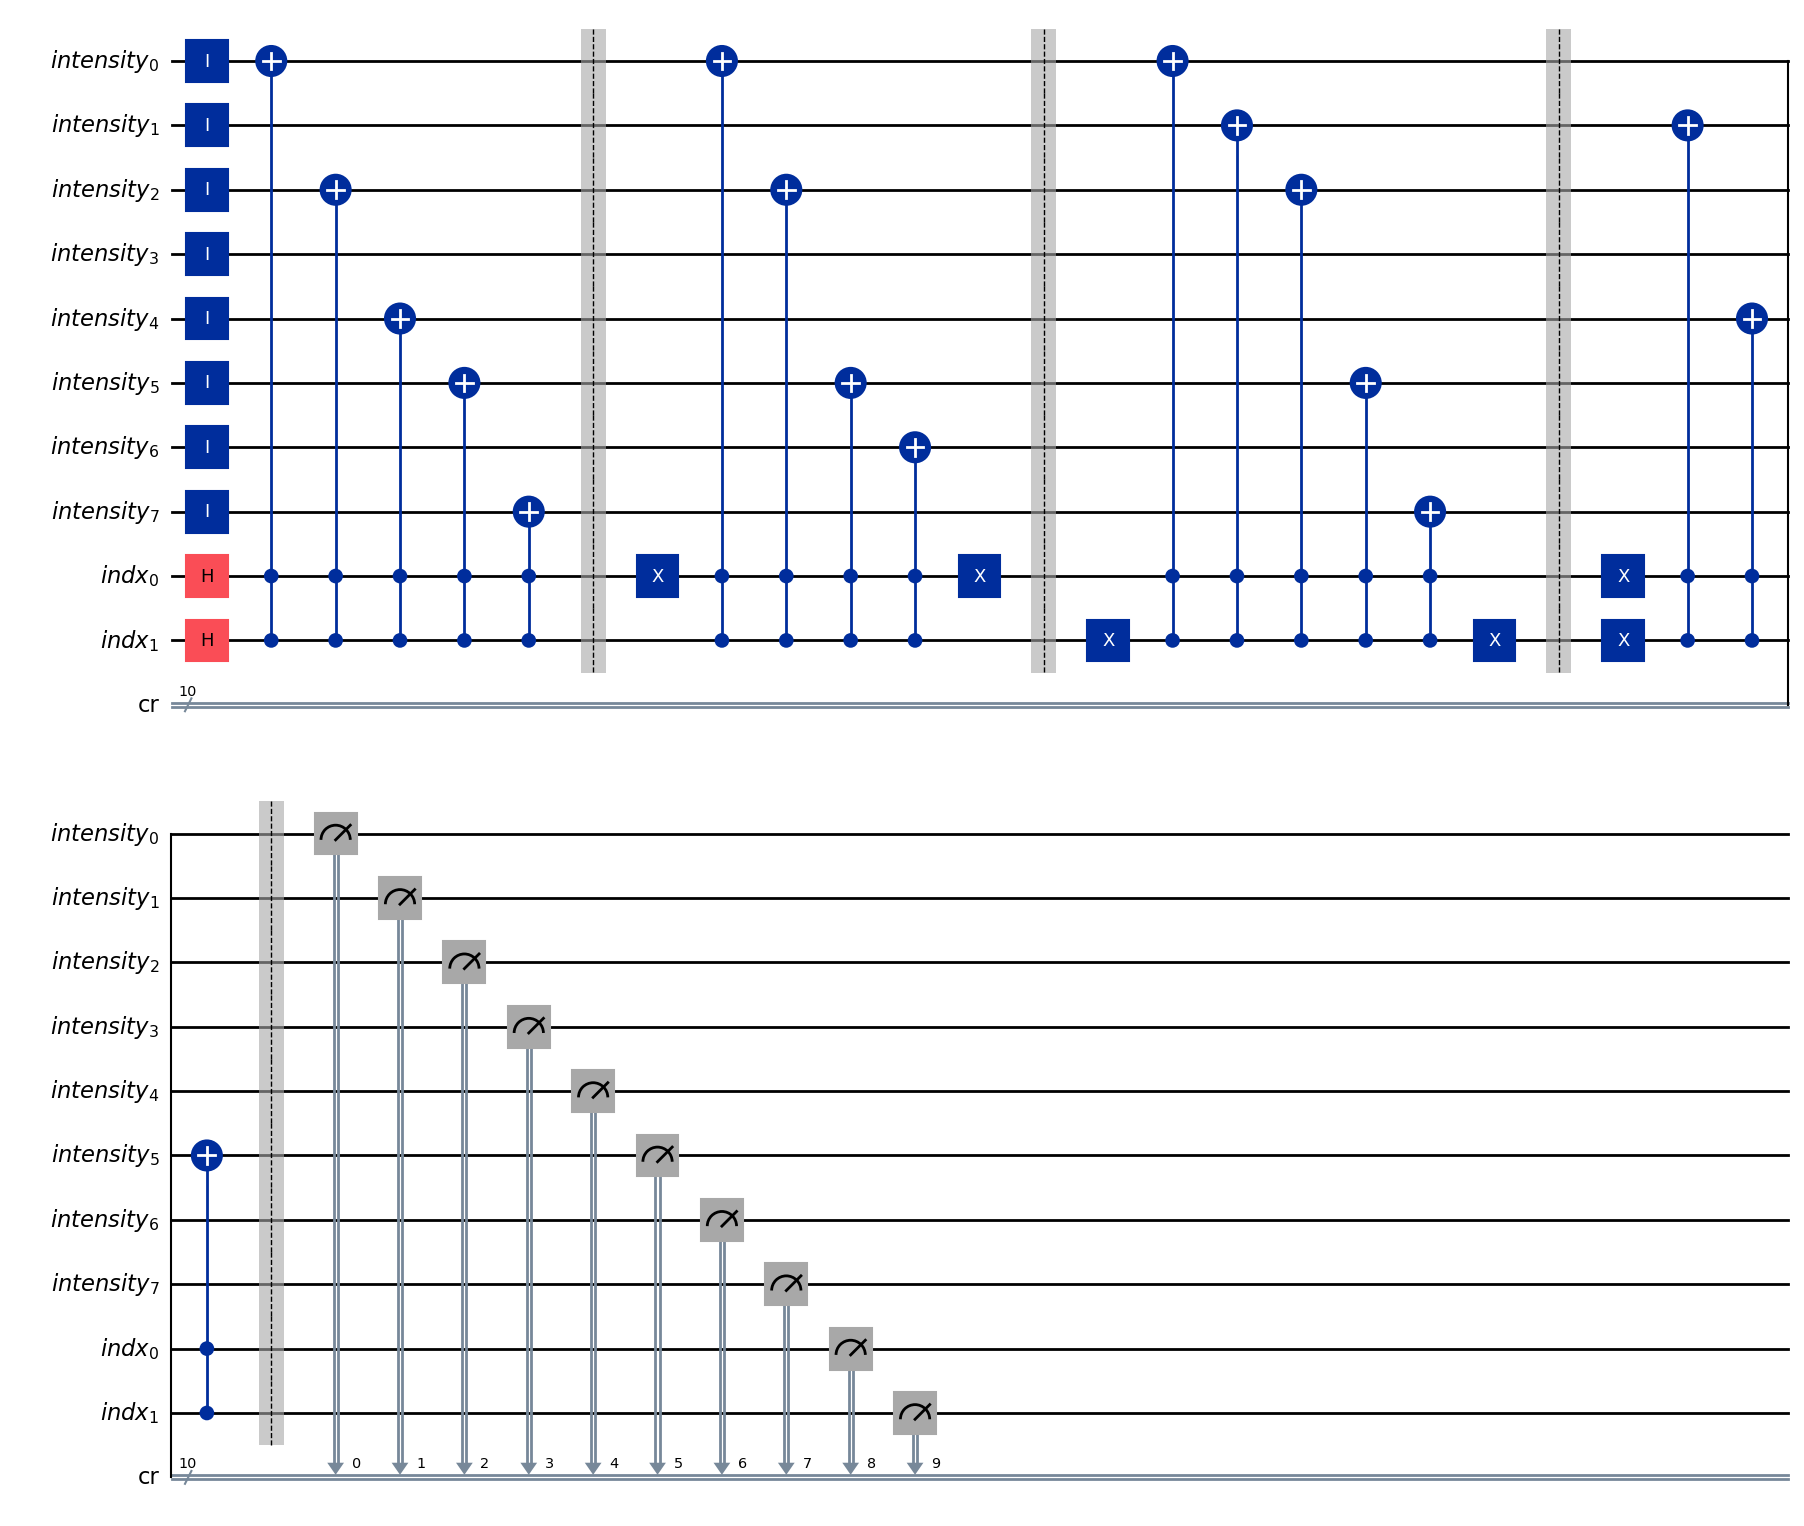

In [43]:
qc_image.draw('mpl')

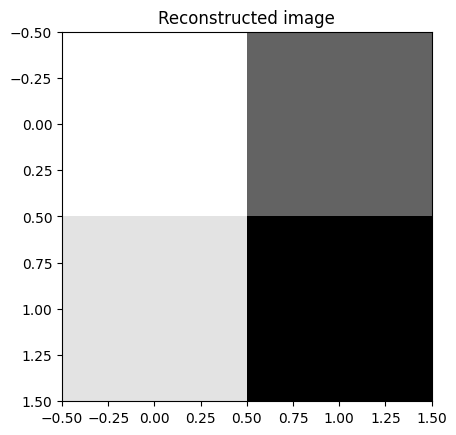

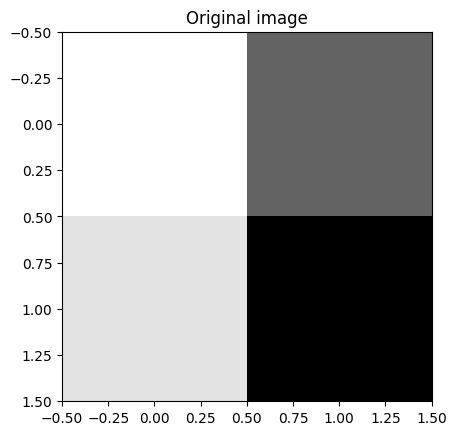

[181. 101. 167.  50.] 
 [181 101 167  50]


In [ ]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
result_neqr = aer_sim.run(t_qc_image, shots=8192).result()
counts_neqr = result_neqr.get_counts()
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))
plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())